# 2. Machine Learning Modeling

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from feature_engine.creation import CyclicalFeatures
from feature_engine.transformation import LogCpTransformer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (LagFeatures, WindowFeatures)
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             mean_absolute_error, 
                             mean_absolute_percentage_error
                            )

In [3]:
price_df = pd.read_csv("../data/processed/price_actual_df.csv", parse_dates=["time"])
price_df = price_df.set_index("time") \
                   .asfreq("H") \
                   .sort_index()

In [4]:
price_df.head()

,price actual
time,
2015-01-01 00:00:00+01:00,65.41
2015-01-01 01:00:00+01:00,64.92
2015-01-01 02:00:00+01:00,64.48
2015-01-01 03:00:00+01:00,59.32
2015-01-01 04:00:00+01:00,56.04


## Time series data preparation

### 1. Outliers detection and removal

In [5]:
def remove_outliers(df, value_col, period = None, robust = True):
    serie = df[value_col]
    res = STL(serie, period = period, robust = robust).fit()
    resid = res.resid
    q1 = resid.quantile(0.25)
    q3 = resid.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - (3*iqr)
    upper = q3 + (3*iqr)
    
    anomalies = serie[(resid < lower) | (resid >= upper)]
    df = df.assign(anomaly = np.where(df[value_col].index.isin(anomalies.index), True, False))
    df["value_corrected"] = np.where(df["anomaly"] == True, np.NaN, df[value_col])
    df.interpolate(method = "linear", inplace=True)
    df["value_corrected"] = np.where(df["value_corrected"].isna(), df[value_col], df["value_corrected"])
    return df

In [7]:
data_sin_outliers = remove_outliers(price_df, 'price actual')
data_sin_outliers = data_sin_outliers.drop(["price actual", "anomaly"], axis=1)

<Axes: xlabel='time'>

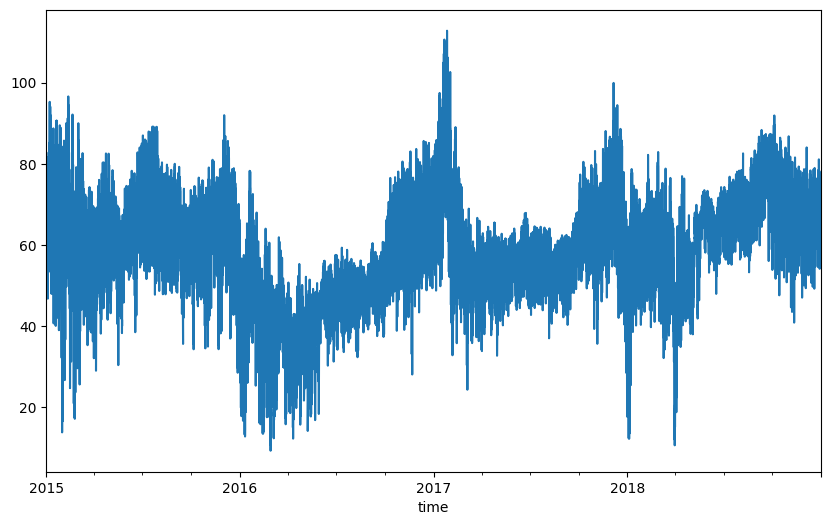

In [8]:
data_sin_outliers['value_corrected'].plot(figsize=(10,6))

In [13]:
# Validation split
val_len = 24
in_sample_df = data_sin_outliers.iloc[:-val_len, :]
out_of_sample_df = data_sin_outliers.iloc[-val_len:, :]

In [14]:
in_sample_df = in_sample_df.reset_index()
out_of_sample_df = out_of_sample_df.reset_index()

In [16]:
# Train test split
test_time = pd.Timedelta(24*7, unit='H')
split_point = in_sample_df['time'].max() - test_time

X_train = in_sample_df[in_sample_df['time'] < split_point]
X_test = in_sample_df[in_sample_df['time'] >= split_point - pd.Timedelta(24*4, unit = 'H')]

y_train = in_sample_df[in_sample_df['time'] < split_point][['time', 'value_corrected']]
y_test = in_sample_df[in_sample_df['time'] >= split_point - pd.Timedelta(24*4, unit='H')][['time', 'value_corrected']]

In [18]:
X_train = X_train.set_index('time')
X_test = X_test.set_index('time')
y_train = y_train.set_index('time')
y_test = y_test.set_index('time')

## Feature Engineering

In [19]:
# Fourier Features Class
class AddFourierFeatures(BaseEstimator, TransformerMixin):
    seconds_per_day = 24*60*60     # Daily dataset
    seconds_per_hour = 60*60       # Hourly dataset

    def __init__(self, K, periods: list, by = "day"):
        self.K = K
        self.periods = periods
        self.by = by

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):
        X = X.copy()
        dates = X.index
        
        for period in self.periods:
            term = self.K / period
            timestamps = dates.map(datetime.datetime.timestamp)
            ts_scaled = []

            for ts in timestamps:
                if self.by == "day":
                    x_scaled = round(ts / self.seconds_per_day)
                    ts_scaled.append(x_scaled)
                else:
                    x_scaled = round(ts / self.seconds_per_hour)
                    ts_scaled.append(x_scaled)

            X["fourier_sin"] = [np.sin(2 * np.pi * term * ts) for ts in ts_scaled]
            X["fourier_cos"] = [np.cos(2 * np.pi * term * ts) for ts in ts_scaled]

        return X

In [27]:
# Transformers
horizon = 24 # 24 hours

dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "hour",
        "day_of_month",
        "month",
        "year",
        "day_of_year",
        "week",
        "day_of_week",
        "weekend",
        "quarter",
        "semester"
    ],
    drop_original = False,
    utc = True
)

cyclicf = CyclicalFeatures(
    variables=["hour", "month", "day_of_year"],
    drop_original= True
)

fourierf = AddFourierFeatures(
    K = 1,
    periods=[horizon, horizon*2],
    by = "hour"
)

lagf = LagFeatures(
    variables="value_corrected",
    periods=list(range(1,horizon+2)),
    missing_values = "ignore"
)

windf24 = WindowFeatures(
    variables="value_corrected",
    functions=["mean", "std"],
    window=[horizon],
    freq="1H",
    missing_values="ignore"
)

imputer = DropMissingData()

drop_features = DropFeatures(features_to_drop=["value_corrected"])

In [28]:
prep_pipeline = Pipeline([
    ('datetime features', dtf),
    ('cyclic features', cyclicf),
    ("fourier features", fourierf),
    ('lag features', lagf),
    ('window features', windf24),
    ('imputer', imputer),
    ('drop features', drop_features)
])

X_train_prep = prep_pipeline.fit_transform(X_train)
X_test_prep = prep_pipeline.transform(X_test)

In [30]:
# Align
y_train_t = y_train.loc[X_train_prep.index]
y_test_t = y_test.loc[X_test_prep.index]

# 1. XGBoost Model

In [33]:
# Fit model
model = xgb.XGBRegressor(random_state = 42)
model.fit(X_train_prep, y_train_t)

# Predict
preds = model.predict(X_test_prep)
train_preds = model.predict(X_train_prep)

# Evaluate in test set
test_mae = mean_absolute_error(y_test_t, preds)

# Evaluate in train set
train_mae = mean_absolute_error(y_train_t, train_preds)

# Compare
print(f"MAE in test: {test_mae}, MAE in train: {train_mae}")

MAE in test: 1.1943125197092692, MAE in train: 1.0690914108180416


In [34]:
# Plot results
results = pd.DataFrame(X_test_prep.copy(), columns=X_test_prep.columns)
results["pred"] = preds
results["actual"] = y_test
results["error"] = results["actual"] - results["pred"]
results = results.reset_index()

In [35]:
def plot_model_performance(df):
    plt.figure(figsize = (8,4))
    # Histogram
    plt.subplot(1,2,1)
    plt.hist(df["error"], bins=20)
    plt.xlabel("Forecast Error")
    plt.ylabel("Density")
    
    # Real - Preds
    plt.subplot(1,2,2)
    plt.scatter(df.actual, df.pred)
    p1 = max(max(df.pred), max(df.actual))
    p2 = min(min(df.pred), min(df.actual))
    plt.plot([p1, p2], [p1, p2], 'r-')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    plt.tight_layout()

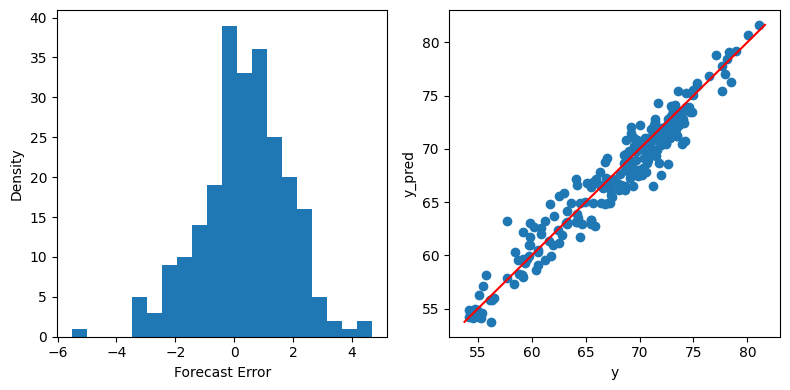

In [36]:
plot_model_performance(results)

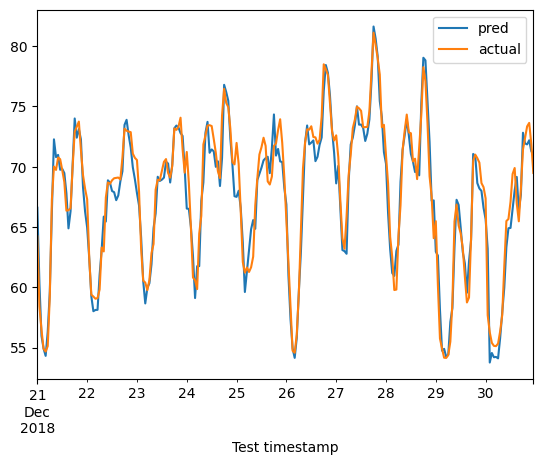

In [38]:
# Plot test predictions
results[['time','pred', 'actual']].set_index('time').plot()
plt.xlabel('Test timestamp')
plt.show()

In [39]:
def give_me_metrics(df):
    mae_test = mean_absolute_error(df.actual, df.pred)
    mse_test = mean_squared_error(df.actual, df.pred)
    rmse_test = mean_squared_error(df.actual, df.pred, squared=False)
    mape_test = mean_absolute_percentage_error(df.actual, df.pred)
    r2_test = r2_score(df.actual, df.pred)

    metric_df = pd.DataFrame({'MAE': [mae_test], 'MSE' : [mse_test], 'RMSE' : [rmse_test], 'MAPE': [mape_test], 'R2':[r2_test]})
    return metric_df

In [42]:
metrics = give_me_metrics(results)
metrics["model"] = "XGBoost"
metrics.set_index("model")

,MAE,MSE,RMSE,MAPE,R2
model,,,,,
XGBoost,1.194313,2.347018,1.531998,0.017769,0.936853


# 2. Random Forest

In [43]:
# Fit model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_prep, y_train_t)

# Predict
preds = model.predict(X_test_prep)
train_preds = model.predict(X_train_prep)

# Evaluate in test set
test_mae = mean_absolute_error(y_test_t, preds)

# Evaluate in train set
train_mae = mean_absolute_error(y_train_t, train_preds)

# Compare
print(f"MAE in test: {test_mae}, MAE in train: {train_mae}")

MAE in test: 1.0044405757629287, MAE in train: 0.5403116997928945


In [44]:
# Plot results
results = pd.DataFrame(X_test_prep.copy(), columns=X_test_prep.columns)
results["pred"] = preds
results["actual"] = y_test
results["error"] = results["actual"] - results["pred"]
results = results.reset_index()

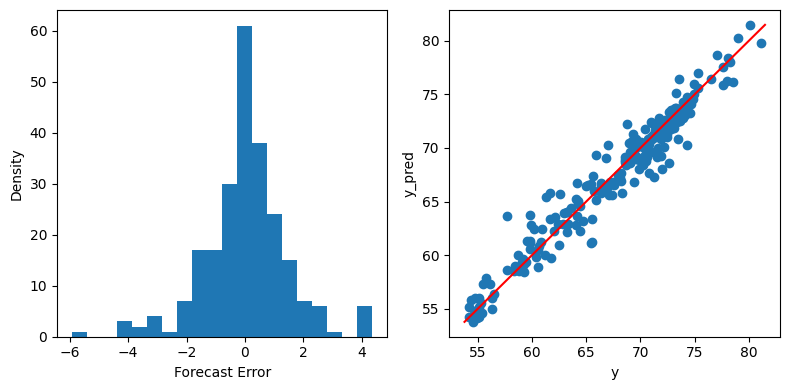

In [45]:
plot_model_performance(results)

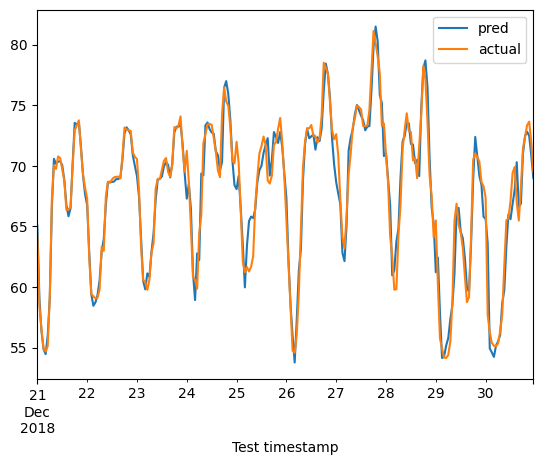

In [46]:
# Plot test predictions
results[['time','pred', 'actual']].set_index('time').plot()
plt.xlabel('Test timestamp')
plt.show()

In [47]:
metrics = give_me_metrics(results)
metrics["model"] = "RandomForest"
metrics.set_index("model")

,MAE,MSE,RMSE,MAPE,R2
model,,,,,
RandomForest,1.004441,2.049127,1.431477,0.015068,0.944868


# 3. LightGBM

In [48]:
# Fit model
model = lgbm.LGBMRegressor(random_state=42)
model.fit(X_train_prep, y_train_t)

# Predict
preds = model.predict(X_test_prep)
train_preds = model.predict(X_train_prep)

# Evaluate in test set
test_mae = mean_absolute_error(y_test_t, preds)

# Evaluate in train set
train_mae = mean_absolute_error(y_train_t, train_preds)

# Compare
print(f"MAE in test: {test_mae}, MAE in train: {train_mae}")

MAE in test: 1.163942025550122, MAE in train: 1.3332401353457806


In [49]:
# Plot results
results = pd.DataFrame(X_test_prep.copy(), columns=X_test_prep.columns)
results["pred"] = preds
results["actual"] = y_test
results["error"] = results["actual"] - results["pred"]
results = results.reset_index()

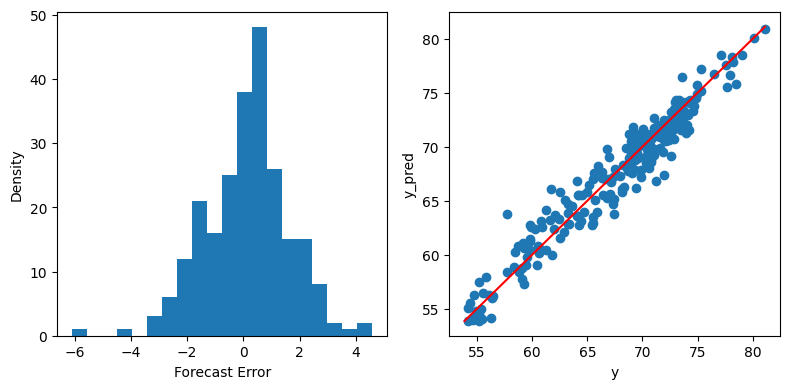

In [50]:
plot_model_performance(results)

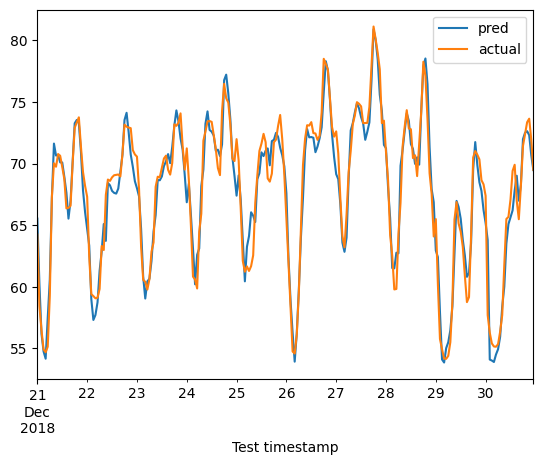

In [51]:
# Plot test predictions
results[['time','pred', 'actual']].set_index('time').plot()
plt.xlabel('Test timestamp')
plt.show()

In [52]:
metrics = give_me_metrics(results)
metrics["model"] = "LGBMRegressor"
metrics.set_index("model")

,MAE,MSE,RMSE,MAPE,R2
model,,,,,
LGBMRegressor,1.163942,2.270151,1.506702,0.017485,0.938921


# 4. ElasticNet

In [53]:
# Fit model
model = ElasticNet(random_state=42)
model.fit(X_train_prep, y_train_t)

# Predict
preds = model.predict(X_test_prep)
train_preds = model.predict(X_train_prep)

# Evaluate in test set
test_mae = mean_absolute_error(y_test_t, preds)

# Evaluate in train set
train_mae = mean_absolute_error(y_train_t, train_preds)

# Compare
print(f"MAE in test: {test_mae}, MAE in train: {train_mae}")

MAE in test: 1.2591308977135673, MAE in train: 1.6236061031361513


In [54]:
# Plot results
results = pd.DataFrame(X_test_prep.copy(), columns=X_test_prep.columns)
results["pred"] = preds
results["actual"] = y_test
results["error"] = results["actual"] - results["pred"]
results = results.reset_index()

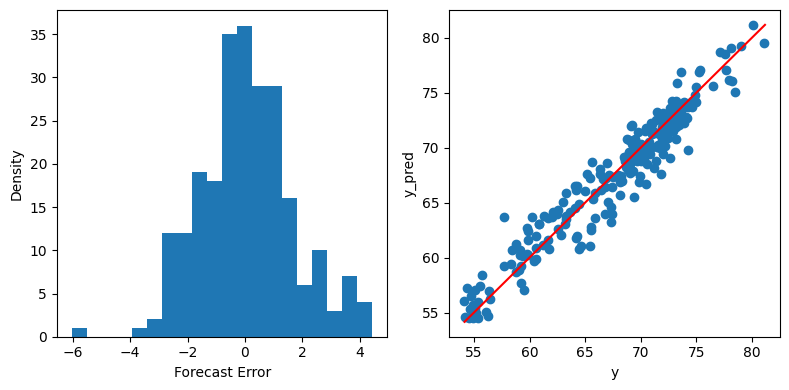

In [55]:
plot_model_performance(results)

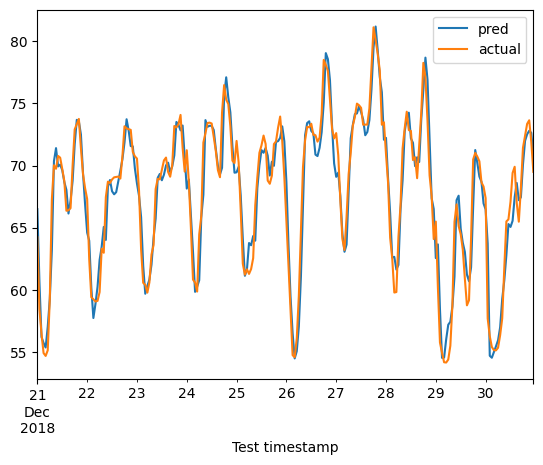

In [56]:
# Plot test predictions
results[['time','pred', 'actual']].set_index('time').plot()
plt.xlabel('Test timestamp')
plt.show()

In [57]:
metrics = give_me_metrics(results)
metrics["model"] = "ElasticNet"
metrics.set_index("model")

,MAE,MSE,RMSE,MAPE,R2
model,,,,,
ElasticNet,1.259131,2.688086,1.639538,0.018882,0.927676
